# Kings County Analysis

#### Import Libraries and Data

In [1]:
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
kings_county_df = pd.read_csv("data/kc_house_data_train.csv", index_col='Unnamed: 0')
kings_county_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Check descriptive stats and info about each column

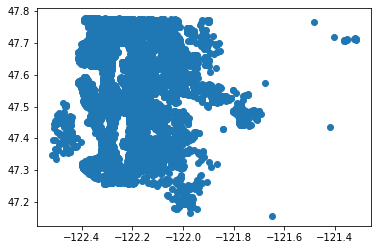

In [3]:
plt.scatter( kings_county_df['long'], kings_county_df['lat'])

In [4]:
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

#### Data Cleaning

- Convert date to DateTime Object
- Took count of ID, if id appeared more than once, sold more than once.
- Drop Unnamed Column and ID: Seems irrelevant
- Drop long/lat, I don't think i can think of any good combination that isn't explained by zip code
- Convert zipcode to string

In [5]:
kings_county_df['date'] = pd.to_datetime(kings_county_df['date'].str.slice(0,8),format="%Y-%m-%d")
dictNumTimesSold = dict(kings_county_df.groupby('id').id.count().sort_values())
kings_county_df['num_times_sold'] = kings_county_df['id'].map(dictNumTimesSold)
kings_county_df.drop(labels =['id', 'lat', 'long'], axis=1, inplace=True)
kings_county_df['zipcode'] = kings_county_df['zipcode'].apply(str)

View extreme numbers and address accordingly. Saw a bedroom of 33 and it looks like a typo so set it to 3 bedrooms. Saw 0 bedrooms/0 bathrooms, but may be the test data will have them so I'm leaving them accordingly.

In [6]:
kings_county_df.query("bedrooms == 33")

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,num_times_sold
8597,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700,1


In [7]:
kings_county_df.at[8597,'bedrooms'] = 3

In [8]:
kings_county_df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

In [9]:
kings_county_df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

Check for NAs

In [10]:
kings_county_df.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view              0
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
sqft_living15     0
sqft_lot15        0
num_times_sold    0
dtype: int64

In [11]:
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            17290 non-null  datetime64[ns]
 1   price           17290 non-null  float64       
 2   bedrooms        17290 non-null  int64         
 3   bathrooms       17290 non-null  float64       
 4   sqft_living     17290 non-null  int64         
 5   sqft_lot        17290 non-null  int64         
 6   floors          17290 non-null  float64       
 7   waterfront      17290 non-null  int64         
 8   view            17290 non-null  int64         
 9   condition       17290 non-null  int64         
 10  grade           17290 non-null  int64         
 11  sqft_above      17290 non-null  int64         
 12  sqft_basement   17290 non-null  int64         
 13  yr_built        17290 non-null  int64         
 14  yr_renovated    17290 non-null  int64         
 15  zi

#### Early Data Analysis

View the range for number of bedrooms 

<AxesSubplot:>

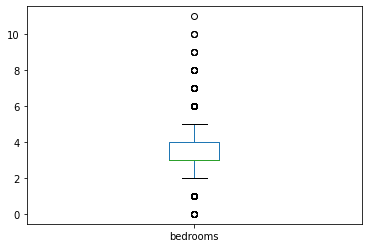

In [12]:
kings_county_df.bedrooms.plot(kind='box')

View the range for number of bathrooms. Mean around 2

<AxesSubplot:>

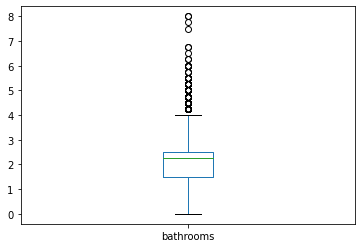

In [13]:
kings_county_df.bathrooms.plot(kind='box')

View average price by bedrooms.

In [14]:
kings_county_df.groupby('bedrooms').price.mean()

bedrooms
0     4.319667e+05
1     3.265255e+05
2     4.006608e+05
3     4.654965e+05
4     6.377381e+05
5     7.847411e+05
6     8.377285e+05
7     9.861672e+05
8     1.255600e+06
9     8.167998e+05
10    8.193333e+05
11    5.200000e+05
Name: price, dtype: float64

View number of bedrooms and handle outliers

<AxesSubplot:>

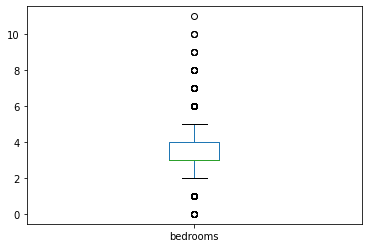

In [15]:
kings_county_df.bedrooms.plot(kind='box')

In [16]:
kings_county_df.bedrooms.value_counts().sort_index()

0       12
1      160
2     2204
3     7865
4     5488
5     1283
6      229
7       30
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

Cap the outliers to a certain number

In [17]:
kings_county_df['bedrooms'] = np.where(kings_county_df['bedrooms'] >= 7, 7, kings_county_df['bedrooms'])

In [18]:
kings_county_df.bedrooms.value_counts().sort_index()

0      12
1     160
2    2204
3    7865
4    5488
5    1283
6     229
7      49
Name: bedrooms, dtype: int64

View bathrooms grouped by mean

View range for bathrooms

<AxesSubplot:>

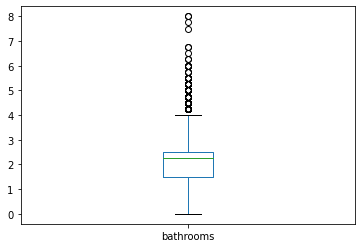

In [19]:
kings_county_df.bathrooms.plot(kind='box')

View count of each bathroom

In [20]:
kings_county_df.bathrooms.value_counts().sort_index()

0.00       8
0.50       3
0.75      52
1.00    3100
1.25       6
1.50    1168
1.75    2431
2.00    1549
2.25    1666
2.50    4322
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      17
5.25      11
5.50       7
5.75       3
6.00       6
6.25       2
6.50       1
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

In [21]:
kings_county_df.groupby('bathrooms').price.mean()

bathrooms
0.00    5.077062e+05
0.50    2.255000e+05
0.75    2.766520e+05
1.00    3.463276e+05
1.25    6.010000e+05
1.50    4.073672e+05
1.75    4.582803e+05
2.00    4.557473e+05
2.25    5.372734e+05
2.50    5.566379e+05
2.75    6.545027e+05
3.00    7.149029e+05
3.25    9.656770e+05
3.50    9.289996e+05
3.75    1.198263e+06
4.00    1.309828e+06
4.25    1.532047e+06
4.50    1.328587e+06
4.75    1.817828e+06
5.00    1.749518e+06
5.25    1.866118e+06
5.50    2.803286e+06
5.75    3.143333e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    2.238890e+06
6.75    2.734000e+06
7.50    4.500000e+05
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64

Cap the bathrooms to a certain number, 6 in this case.

In [22]:
kings_county_df['bathrooms'] = np.where(kings_county_df['bathrooms']==1.25, 1, kings_county_df['bathrooms'])
kings_county_df['bathrooms'] = np.where(kings_county_df['bathrooms']>=5, 5, kings_county_df['bathrooms'])
kings_county_df.bathrooms.value_counts().sort_index()



0.00       8
0.50       3
0.75      52
1.00    3106
1.50    1168
1.75    2431
2.00    1549
2.25    1666
2.50    4322
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      53
Name: bathrooms, dtype: int64

In [23]:
kings_county_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'num_times_sold'],
      dtype='object')

See updated descriptive stats

In [24]:
kings_county_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.368826,2.109933,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,1987.986698,12873.475824,1.013187
std,3.733190e+05,0.901955,0.761316,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,684.802635,27227.437583,0.114077
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,399.000000,659.000000,1.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,1490.000000,5111.250000,1.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,1840.000000,7622.500000,1.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,2360.000000,10101.750000,1.000000
max,7.700000e+06,7.000000,5.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,858132.000000,2.000000


In [25]:
continuous = ['price',  'sqft_living', 'sqft_lot',
         'sqft_above', 'sqft_basement',   
       'sqft_living15','view', 'sqft_lot15']

categorical = ['waterfront','condition','grade',
               'bedrooms', 'bathrooms','floors','zipcode']

See the relationship between the continuous variables and the target variable price

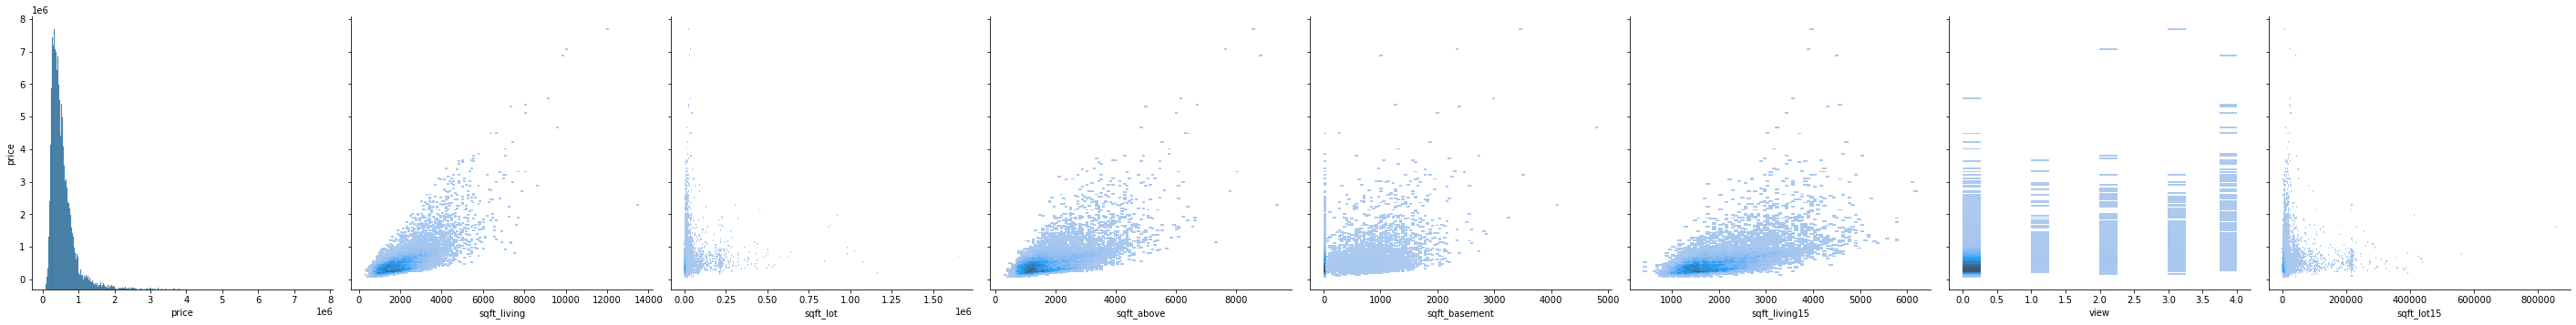

In [26]:
sns.pairplot(data = kings_county_df, y_vars="price", x_vars=continuous, height=5, kind='hist')



View categorical variables against target variable price

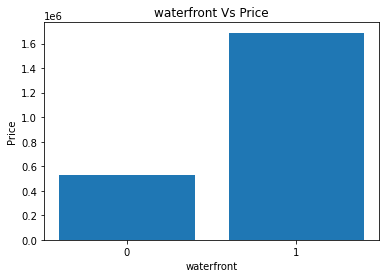

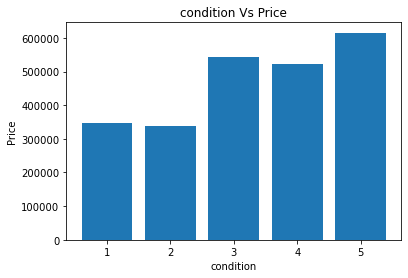

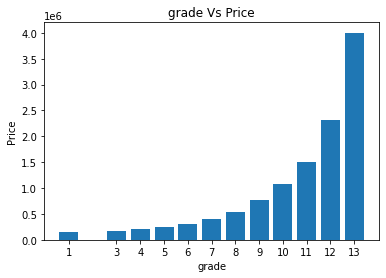

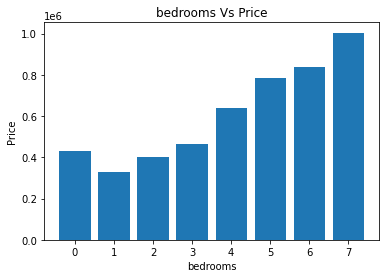

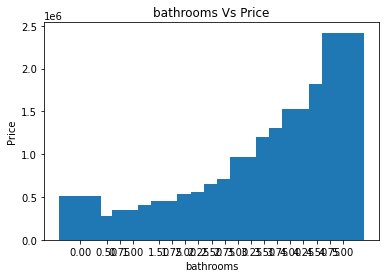

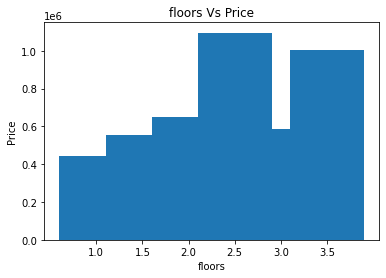

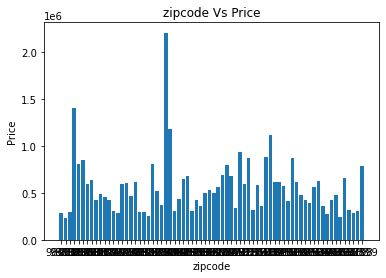

In [27]:
for x in categorical:
    group = kings_county_df.groupby(x).price.mean()
    plt.figure()
    plt.bar(group.index,group.values)
    plt.title(f'{x} Vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)
    plt.xticks(group.index)
    # Show/save figure as desired.
    plt.show()

Categorize grade so it is more linear

In [28]:
conditions = [(kings_county_df['grade'] <= 8),
              (kings_county_df['grade'] <= 12),
             (kings_county_df['grade'] <= 13)]
choices = ['low','medium','high']
kings_county_df['grade_cat'] = np.select(conditions, choices)

H0: Average price of all bedrooms are the same
H1: Average price of all bedrooms are different.

In [29]:
samples = kings_county_df.groupby('bedrooms')['price'].apply(list)
stats.f_oneway(*samples)


F_onewayResult(statistic=290.92340468218185, pvalue=0.0)

View average price by zipcode

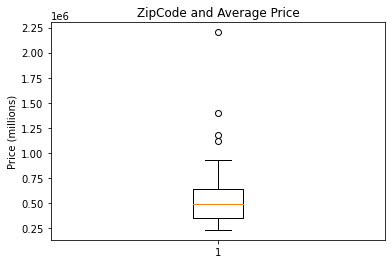

In [30]:
groupedZip = kings_county_df.groupby('zipcode')['price'].mean()

fig, ax = plt.subplots()
ax.boxplot(groupedZip)
ax.set_title('ZipCode and Average Price')
ax.set_ylabel('Price (millions)');

In [31]:
outlier_zips = list((kings_county_df.groupby('zipcode').price.mean().sort_values(ascending=False)).index)[:4]
outlier_zips = ['zipcode_' + sub for sub in outlier_zips]
outlier_zips

['zipcode_98039', 'zipcode_98004', 'zipcode_98040', 'zipcode_98112']

Visualize average price by zipcode

H0: Average price is the same across zipcodes<br>
H1: Average price isn't the same across zipcodes

In [32]:
#alpha = .05
samples = kings_county_df.groupby('zipcode')['price'].apply(list)
stats.f_oneway(*samples)


F_onewayResult(statistic=167.38619664118102, pvalue=0.0)

<BarContainer object of 70 artists>

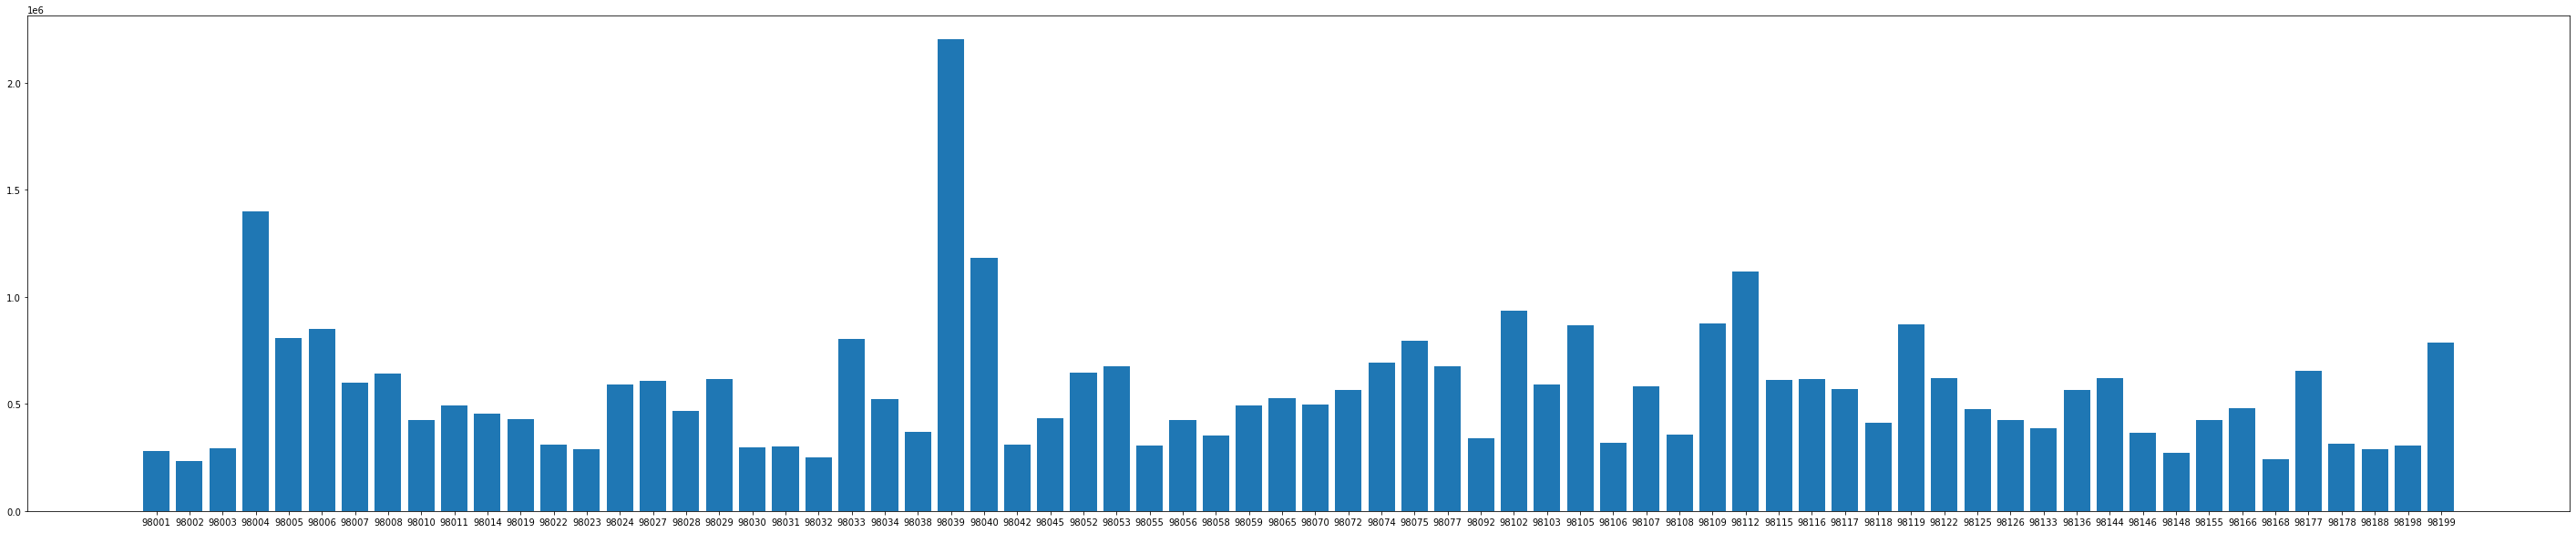

In [33]:
groupedZip = kings_county_df.groupby('zipcode')['price'].mean()

fig, ax = plt.subplots(figsize=(50,10))
ax.bar(x = groupedZip.index,
        height = groupedZip.values)


H0: Average price is the same whether a house has or doesn't have a waterfront<br>
H1: Average price isn't the same whether a house has or doesn't have a waterfront

In [34]:
kings_county_df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

In [35]:
#alpha = .05

stats.ttest_ind(kings_county_df.query("waterfront == True")['price'], kings_county_df.query("waterfront == False")['price'])



Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

Check for any correlation

In [36]:
kings_county_df.corr()>.9

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [37]:
categorical = ['condition','grade_cat','bedrooms', 'bathrooms','floors','zipcode']

Create dummy variables for categoricals

In [38]:
kc_DF_wDUMS = pd.get_dummies(kings_county_df, columns=categorical, drop_first=True)
kc_DF_wDUMS.head()

,date,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,2,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,2,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


View amount of houses by zip code

In [39]:
kc_DF_wDUMS.iloc[:, 49:].sum().sort_values()

floors_3.5         7
zipcode_98039     42
zipcode_98148     43
zipcode_98024     65
zipcode_98010     74
zipcode_98102     80
zipcode_98109     85
zipcode_98070     99
zipcode_98014    101
zipcode_98032    103
zipcode_98188    109
zipcode_98007    122
zipcode_98005    140
zipcode_98019    145
zipcode_98119    149
zipcode_98108    151
zipcode_98002    157
zipcode_98077    162
zipcode_98011    163
zipcode_98105    170
zipcode_98045    176
zipcode_98022    189
zipcode_98030    201
zipcode_98166    209
zipcode_98055    210
zipcode_98107    212
zipcode_98136    214
zipcode_98031    215
zipcode_98168    215
zipcode_98072    215
zipcode_98178    215
zipcode_98112    216
zipcode_98177    218
zipcode_98028    219
zipcode_98198    220
zipcode_98003    224
zipcode_98008    226
zipcode_98040    229
zipcode_98122    235
zipcode_98004    237
zipcode_98146    246
zipcode_98065    249
zipcode_98029    250
zipcode_98199    266
zipcode_98106    266
zipcode_98116    266
zipcode_98144    269
zipcode_98126

Get all zips in a list

In [40]:
all_zips = list((kings_county_df.groupby('zipcode').price.mean().sort_index(ascending=True)).index)[1:]
all_zips = ['zipcode_' + sub for sub in all_zips]


Check for outliers in price

<AxesSubplot:>

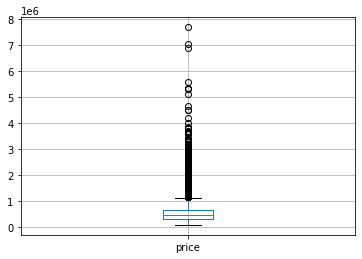

In [41]:
kc_DF_wDUMS.boxplot(['price'],)

In [42]:
kc_DF_wDUMS.sort_values('price', ascending=False)

,date,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
10366,2014-10-13,7700000.0,12050,27600,0,3,13,8570,3480,1910,1987,3940,8800,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6903,2014-06-11,7062500.0,10040,37325,1,2,11,7680,2360,1940,2001,3930,25449,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7519,2014-09-19,6885000.0,9890,31374,0,4,13,8860,1030,2001,0,4540,42730,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2232,2014-08-04,5570000.0,9200,35069,0,0,13,6200,3000,2001,0,3560,24345,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1979,2015-04-13,5350000.0,8000,23985,0,4,12,6720,1280,2009,0,4600,21750,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,2014-05-08,82500.0,520,22334,0,0,5,520,0,1951,0,1572,10570,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15956,2014-11-05,82000.0,860,10426,0,0,6,860,0,1954,0,1140,11250,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [43]:
above_10std = kc_DF_wDUMS.price.mean()+(10*kc_DF_wDUMS.price.std())
above_10std



4273929.336133626

In [44]:
kc_DF_wDUMS.shape

(17290, 119)

Remove the outliers more than 10 std

In [45]:
kc_DF_wDUMS = kc_DF_wDUMS[(kc_DF_wDUMS['price']<=above_10std)]

kc_DF_wDUMS[(kc_DF_wDUMS['price']<=above_10std)].shape


(17280, 119)

### Feature Engineering

Created a few new columns: <br>
    
    - Age as in age of the house
    - Converted yr_built to a datetime obj
    - Created a bool column for if a house was renovated
    - Created a column for the month the house was sold
    - Created a column for the year the house was sold
    - Created a column for the season the house was sold
    

In [46]:
kc_DF_wDUMS.head()

,date,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,2,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,2,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


***age***

Create age of home column

In [47]:
kc_DF_wDUMS['age'] = 2021 - kings_county_df.yr_built
kc_DF_wDUMS.drop('yr_built',axis=1, inplace=True)
kc_DF_wDUMS['age'].value_counts()


7      453
17     359
16     344
15     343
18     337
14     335
44     323
43     313
53     298
54     294
13     281
42     272
62     260
67     255
31     253
20     252
59     250
34     236
32     234
66     231
52     231
22     215
74     213
33     213
58     211
55     206
61     202
41     201
45     197
71     196
37     196
23     191
27     188
79     188
69     184
70     184
36     183
68     181
73     180
60     176
30     176
63     175
35     173
28     173
21     171
8      169
65     166
12     166
40     164
19     164
29     163
64     162
25     157
38     156
56     151
95     151
72     150
46     144
26     141
24     139
96     139
57     139
78     136
80     133
9      126
48     124
49     120
47     117
81     116
77     115
97     111
111    111
11     106
93     105
51     104
75     101
94     100
10     100
103    100
39      86
92      84
50      82
82      82
91      77
112     75
99      74
101     74
76      73
115     73
121     70
113     69

<AxesSubplot:>

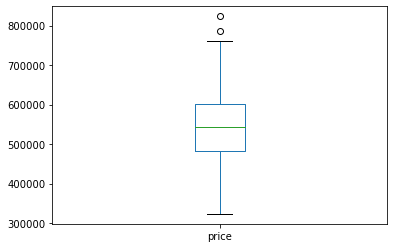

In [48]:
kc_DF_wDUMS.groupby('age').price.mean().plot(kind='box')

Strip date for month sold

In [49]:
kc_DF_wDUMS['month_sold'] = kings_county_df['date'].dt.month
kc_DF_wDUMS['month_sold'].value_counts()


5     1928
4     1802
7     1761
6     1750
8     1559
3     1496
10    1491
9     1387
12    1170
11    1154
2      990
1      792
Name: month_sold, dtype: int64

Strip date for year sold 

In [50]:
kc_DF_wDUMS['year_sold'] = kc_DF_wDUMS['date'].dt.year
kc_DF_wDUMS['year_sold'].value_counts()

2014    11695
2015     5585
Name: year_sold, dtype: int64

In [51]:
kc_DF_wDUMS.drop('date',axis=1, inplace=True)


***month***

H0: Average price was the same across months. <br>
H1: Average price was not the same across months.

In [52]:
#alpha = .05
samples = kc_DF_wDUMS.groupby('month_sold')['price'].apply(list)

stats.f_oneway(*samples)

F_onewayResult(statistic=2.5869970236188466, pvalue=0.00276982469264964)

In [53]:
kc_DF_wDUMS.month_sold.value_counts().sort_index()

1      792
2      990
3     1496
4     1802
5     1928
6     1750
7     1761
8     1559
9     1387
10    1491
11    1154
12    1170
Name: month_sold, dtype: int64

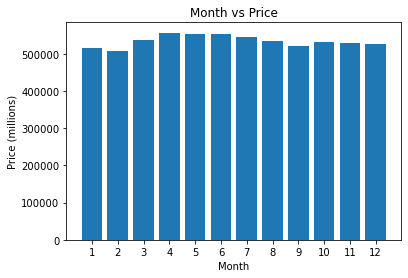

In [54]:
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('month_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Month vs Price")
ax.set_xlabel("Month")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***season***

In [55]:
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
#{1: Winter, 2: Spring, 3: Summer, 4: Fall}
month_to_season = dict(zip(range(1,13), seasons))
kc_DF_wDUMS['season_sold'] = kc_DF_wDUMS.month_sold.map(month_to_season)
kc_DF_wDUMS['season_sold'].value_counts()


Spring    5226
Summer    5070
Fall      4032
Winter    2952
Name: season_sold, dtype: int64

H0: Average price was the same across seasons <br>
H1: Average price wasn't the same across seasons

In [56]:
#alpha = .05
samples = kc_DF_wDUMS.groupby('season_sold')['price'].apply(list)


fstat, pstat = stats.f_oneway(*samples)
fstat,pstat

(7.0674672039289055, 9.613058078826307e-05)

In [57]:
kc_DF_wDUMS.season_sold.value_counts()

Spring    5226
Summer    5070
Fall      4032
Winter    2952
Name: season_sold, dtype: int64

In [58]:
kc_DF_wDUMS.groupby('season_sold')['price'].mean()

season_sold
Fall      527923.862599
Spring    550115.135094
Summer    544598.862327
Winter    517664.144309
Name: price, dtype: float64

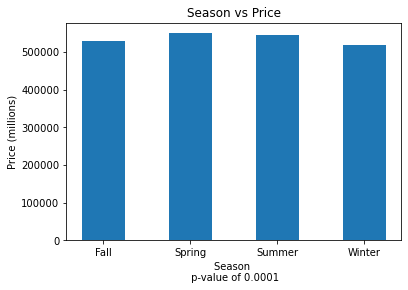

In [59]:
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('season_sold')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .50)
ax.set_title("Season vs Price")
ax.set_xlabel(f"Season \n p-value of {round(pstat,4)}")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***year_sold***

H0: Average price was the same across years. <br>
H1: Average price wasn't the same across years

In [60]:
#alpha = .05

samples = kc_DF_wDUMS.groupby('year_sold')['price'].apply(list)
stats.ttest_ind(*samples)

Ttest_indResult(statistic=0.002645546538374479, pvalue=0.997889192266614)

In [61]:
kc_DF_wDUMS.year_sold.value_counts()

2014    11695
2015     5585
Name: year_sold, dtype: int64

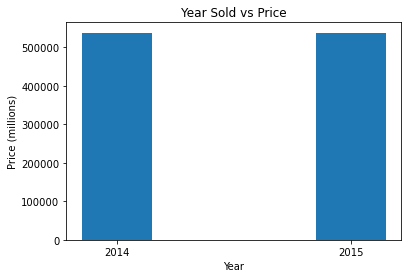

In [62]:

fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('year_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .30)
ax.set_title("Year Sold vs Price")
ax.set_xlabel("Year")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***grade***

H0: Average price is the same with regards to grade <br>
H1: Average price isn't the same

In [63]:
samples = kings_county_df.groupby('grade')['price'].apply(list)

stats.f_oneway(*samples)

F_onewayResult(statistic=1763.5110290471393, pvalue=0.0)

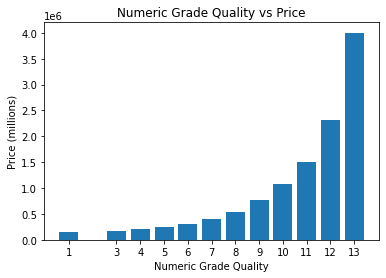

In [64]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Numeric Grade Quality vs Price")
ax.set_xlabel("Numeric Grade Quality")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

In [65]:
samples = kings_county_df.groupby('grade_cat')['price'].apply(list)

fstat, pval = stats.f_oneway(*samples)
fstat, pval

(4810.289855501282, 0.0)

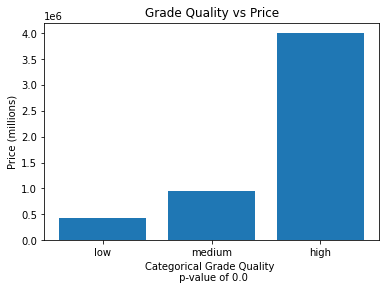

In [66]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade_cat')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Grade Quality vs Price")
ax.set_xlabel(f"Categorical Grade Quality \n p-value of {pval}")
ax.set_ylabel("Price (millions)");

***views***

H0: Average price is the same whether or not the house has a view <br>
H1: Average price isn't the same whether or not the house has a view

In [67]:
#alpha = .05

stats.ttest_ind(kings_county_df.query("view==True")['price'],kings_county_df.query("view == False")['price'])


Ttest_indResult(statistic=17.335586885770702, pvalue=1.0461414698919182e-66)

In [68]:
kings_county_df.view.unique()

array([0, 2, 3, 4, 1])

H0: Amount of views have the same average price <br>
H1: Amount of view do not have the same average price.

In [69]:
samples = kings_county_df.groupby('view')['price'].apply(list)
stats.f_oneway(*samples)

F_onewayResult(statistic=876.7689357683041, pvalue=0.0)

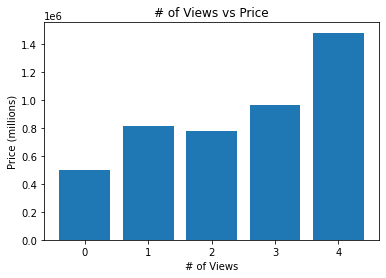

In [70]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('view')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("# of Views vs Price")
ax.set_xlabel("# of Views")
ax.set_ylabel("Price (millions)");

***is_renovated***

In [71]:
kc_DF_wDUMS['is_renovated'] = np.where(kc_DF_wDUMS['yr_renovated'] > 0, 1, 0)
kc_DF_wDUMS.drop('yr_renovated',axis=1, inplace=True)
kc_DF_wDUMS['is_renovated'].value_counts()


0    16557
1      723
Name: is_renovated, dtype: int64

H0: Average price is the same whether a house is or isn't renovated <br>
H1: Average price is not the same whether a house is or isn't renovated


In [72]:
#alpha = .05
stats.ttest_ind(kc_DF_wDUMS.query("is_renovated == True")['price'], kc_DF_wDUMS.query("is_renovated == False")['price'])


Ttest_indResult(statistic=14.827852250606329, pvalue=1.948690132098792e-49)

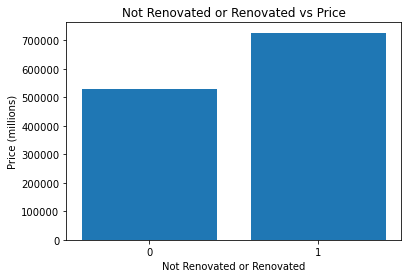

In [73]:
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('is_renovated')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Not Renovated or Renovated vs Price")
ax.set_xlabel("Not Renovated or Renovated")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

#### Linear Regression

Create dummies for season_sold as well

In [74]:
kc_DF_wDUMS = pd.get_dummies(kc_DF_wDUMS, columns = ['season_sold'], drop_first=True)


In [75]:
kc_DF_wDUMS.describe()

,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,age,month_sold,year_sold,is_renovated,season_sold_Spring,season_sold_Summer,season_sold_Winter
count,1.728000e+04,17280.000000,1.728000e+04,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.00000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.00000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.000000,17280.00000,17280.000000,17280.000000,17280.000000
mean,5.377750e+05,2077.617650,1.523450e+04,0.007697,0.236979,7.651794,1786.486169,291.131481,1986.918403,12868.024421,1.013194,0.008044,0.650231,0.261227,0.079109,0.804167,0.195370,0.009259,0.127546,0.455150,0.317535,0.073900,0.013079,0.002836,0.000174,0.003009,0.179745,0.067593,0.140683,0.089641,0.096412,0.250116,0.051852,0.034201,0.026331,0.034201,0.007812,0.006192,0.003704,0.00434,0.000926,0.002604,0.088194,0.377894,0.008044,0.027488,0.000405,0.009086,0.012963,0.013542,0.008102,0.022280,0.00706,0.013079,0.004282,0.009433,0.005845,0.008391,0.010937,0.023727,0.003762,0.019213,0.012674,0.014468,0.011632,0.012442,0.005961,0.020486,0.025174,0.026331,0.002315,0.013137,0.024479,0.010185,0.027431,0.018750,0.012153,0.019444,0.022280,0.021586,0.014

In [76]:
import statsmodels.api as sm

In [77]:
X = sm.add_constant(kc_DF_wDUMS[['age','is_renovated','month_sold','season_sold_Spring','season_sold_Summer','season_sold_Winter']])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     61.56
Date:                Thu, 03 Jun 2021   Prob (F-statistic):           7.12e-76
Time:                        14:05:26   Log-Likelihood:            -2.4500e+05
No. Observations:               17280   AIC:                         4.900e+05
Df Residuals:                   17273   BIC:                         4.901e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                5.59e+05   1.38e+04     40.650      0.000    5.32e+05    5.86e+05
age                -1041.0687     92.526    -11.252      0.000   -1222.429    -859.708
is_renovated        2.301e+05   1.36e+04     16.968      0.000    2.04e+05    2.57e+05
month_sold          1113.2616   1181.452      0.942      0.346   -1202.503    3429.026
season_sold_Spring  2.912e+04   1.01e+04      2.896      0.004    9410.528    4.88e+04
season_sold_Summer  2.006e+04   8141.548      2.463      0.014    4096.758     3.6e+04
season_sold_Winter -3463.6616   9808.792     -0.353      0.724   -2.27e+04    1.58e+04
==============================================================================
Omnibus:                    11877.139   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           215100.964
Skew:                           3.102   Prob(JB):                         0.00
Kurtosis:                      19.132   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
kc_DF_wDUMS['winterXsqft_living'] = kc_DF_wDUMS['season_sold_Winter']*kc_DF_wDUMS['sqft_living']

In [79]:
kc_DF_wDUMS['springXsqft_living'] = kc_DF_wDUMS['season_sold_Spring']*kc_DF_wDUMS['sqft_living']


In [80]:
kc_DF_wDUMS['ageXnumTimesSold'] = kc_DF_wDUMS['age']*kc_DF_wDUMS['num_times_sold']

Initial model with only zipcode dummies

In [81]:
subset =[*all_zips]

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     180.6
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:05:26   Log-Likelihood:            -2.4048e+05
No. Observations:               17280   AIC:                         4.811e+05
Df Residuals:                   17210   BIC:                         4.816e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.82e+05   1.59e+04     17.716      0.000    2.51e+05    3.13e+05
zipcode_98002 -4.971e+04   2.67e+04     -1.863      0.062   -1.02e+05    2578.125
zipcode_98003  8763.9215    2.4e+04      0.366      0.715   -3.82e+04    5.57e+04
zipcode_98004  1.061e+06   2.37e+04     44.782      0.000    1.01e+06    1.11e+06
zipcode_98005  5.268e+05   2.77e+04     19.019      0.000    4.73e+05    5.81e+05
zipcode_98006  5.675e+05    2.1e+04     27.045      0.000    5.26e+05    6.09e+05
zipcode_98007  3.156e+05    2.9e+04     10.867      0.000    2.59e+05    3.72e+05
zipcode_98008  3.588e+05   2.39e+04     15.003      0.000    3.12e+05    4.06e+05
zipcode_98010  1.429e+05    3.5e+04      4.081      0.000    7.43e+04    2.11e+05
zipcode_98011  2.086e+05   2.64e+04      7.915      0.000    1.57e+05     2.6e+05
zipcode_98014  1.742e+05   3.11e+04      5.606      0.000    1.13e+05    2.35e+05
zipcode_98019  1.464e+05   2.74e+04      5.348      0.000    9.28e+04       2e+05
zipcode_98022  2.677e+04   2.52e+04      1.063      0.288   -2.26e+04    7.61e+04
zipcode_98023  7573.8820   2.07e+04      0.366      0.715    -3.3e+04    4.82e+04
zipcode_98024   3.09e+05   3.69e+04      8.378      0.000    2.37e+05    3.81e+05
zipcode_98027  3.253e+05   2.17e+04     15.003      0.000    2.83e+05    3.68e+05
zipcode_98028  1.864e+05   2.41e+04      7.728      0.000    1.39e+05    2.34e+05
zipcode_98029  3.337e+05   2.33e+04     14.343      0.000    2.88e+05    3.79e+05
zipcode_98030   1.44e+04   2.47e+04      0.583      0.560   -3.41e+04    6.29e+04
zipcode_98031   1.86e+04   2.42e+04      0.767      0.443   -2.89e+04    6.61e+04
zipcode_98032  -3.04e+04   3.09e+04     -0.985      0.325   -9.09e+04    3.01e+04
zipcode_98033  5.085e+05   2.14e+04     23.799      0.000    4.67e+05     5.5e+05
zipcode_98034  2.419e+05   2.05e+04     11.819      0.000    2.02e+05    2.82e+05
zipcode_98038  8.642e+04   2.03e+04      4.260      0.000    4.67e+04    1.26e+05
zipcode_98039   1.72e+06   4.53e+04     37.958      0.000    1.63e+06    1.81e+06
zipcode_98040  8.675e+05   2.39e+04     36.326      0.000    8.21e+05    9.14e+05
zipcode_98042  2.717e+04   2.06e+04      1.320      0.187   -1.32e+04    6.75e+04
zipcode_98045  1.493e+05   2.57e+04      5.803      0.000    9.89e+04       2e+05
zipcode_98052  3.641e+05   2.01e+04     18.086      0.000    3.25e+05    4.04e+05
zipcode_98053  3.953e+05   2.18e+04     18.131      0.000    3.53e+05    4.38e+05
zipcode_98055  2.485e+04   2.44e+04      1.018      0.309    -2.3e+04    7.27e+04
zipcode_98056  1.415e+05   2.16e+04      6.544      0.000    9.91e+04    1.84e+05
zipcode_98058  7.237e+04    2.1e+04      3.449      0.001    3.12e+04    1.13e+05
zipcode_98059  2.124e+05   2.11e+04     10.053      0.000    1.71e+05    2.54e+05
zipcode_98065  2.452e+05   2.33e+04     10.530   

Initial model with two dummied variables

In [82]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     211.9
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:05:27   Log-Likelihood:            -2.3948e+05
No. Observations:               17280   AIC:                         4.791e+05
Df Residuals:                   17203   BIC:                         4.797e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.103e+05   7.48e+04      2.810      0.005    6.36e+04    3.57e+05
zipcode_98002 -3.593e+04   2.52e+04     -1.426      0.154   -8.53e+04    1.35e+04
zipcode_98003   1.38e+04   2.26e+04      0.610      0.542   -3.06e+04    5.82e+04
zipcode_98004  1.015e+06   2.24e+04     45.348      0.000    9.71e+05    1.06e+06
zipcode_98005  4.815e+05   2.62e+04     18.402      0.000     4.3e+05    5.33e+05
zipcode_98006   5.24e+05   1.98e+04     26.426      0.000    4.85e+05    5.63e+05
zipcode_98007  2.821e+05   2.74e+04     10.285      0.000    2.28e+05    3.36e+05
zipcode_98008  3.228e+05   2.26e+04     14.294      0.000    2.79e+05    3.67e+05
zipcode_98010  1.472e+05    3.3e+04      4.453      0.000    8.24e+04    2.12e+05
zipcode_98011  1.912e+05   2.49e+04      7.681      0.000    1.42e+05     2.4e+05
zipcode_98014   2.12e+05   2.94e+04      7.221      0.000    1.54e+05     2.7e+05
zipcode_98019  1.456e+05   2.58e+04      5.632      0.000    9.49e+04    1.96e+05
zipcode_98022  5.623e+04   2.38e+04      2.365      0.018    9619.095    1.03e+05
zipcode_98023  6827.4105   1.95e+04      0.349      0.727   -3.15e+04    4.51e+04
zipcode_98024   3.12e+05   3.48e+04      8.957      0.000    2.44e+05     3.8e+05
zipcode_98027  3.112e+05   2.05e+04     15.203      0.000    2.71e+05    3.51e+05
zipcode_98028  1.773e+05   2.28e+04      7.787      0.000    1.33e+05    2.22e+05
zipcode_98029   3.28e+05    2.2e+04     14.938      0.000    2.85e+05    3.71e+05
zipcode_98030  3508.4796   2.33e+04      0.150      0.881   -4.22e+04    4.93e+04
zipcode_98031  5991.7282   2.29e+04      0.262      0.794   -3.89e+04    5.09e+04
zipcode_98032 -2.304e+04   2.91e+04     -0.791      0.429   -8.01e+04     3.4e+04
zipcode_98033   4.88e+05   2.02e+04     24.189      0.000    4.48e+05    5.28e+05
zipcode_98034  2.356e+05   1.93e+04     12.196      0.000    1.98e+05    2.73e+05
zipcode_98038   7.91e+04   1.91e+04      4.131      0.000    4.16e+04    1.17e+05
zipcode_98039  1.652e+06   4.28e+04     38.590      0.000    1.57e+06    1.74e+06
zipcode_98040  8.026e+05   2.26e+04     35.511      0.000    7.58e+05    8.47e+05
zipcode_98042  2.843e+04   1.94e+04      1.463      0.143   -9649.596    6.65e+04
zipcode_98045  1.717e+05   2.43e+04      7.068      0.000    1.24e+05    2.19e+05
zipcode_98052  3.384e+05    1.9e+04     17.801      0.000    3.01e+05    3.76e+05
zipcode_98053  4.095e+05   2.06e+04     19.870      0.000    3.69e+05     4.5e+05
zipcode_98055  3.998e+04   2.31e+04      1.734      0.083   -5209.933    8.52e+04
zipcode_98056  1.385e+05   2.04e+04      6.787      0.000    9.85e+04    1.79e+05
zipcode_98058  5.891e+04   1.98e+04      2.974      0.003    2.01e+04    9.77e+04
zipcode_98059  1.776e+05      2e+04      8.903      0.000    1.39e+05    2.17e+05
zipcode_98065  2.307e+05    2.2e+04     10.491   

Model with features that seemed the most significant

In [83]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view', 'grade_cat_low','grade_cat_medium']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     516.1
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:05:27   Log-Likelihood:            -2.3438e+05
No. Observations:               17280   AIC:                         4.689e+05
Df Residuals:                   17196   BIC:                         4.696e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.275e+06   8.73e+04     26.069      0.000     2.1e+06    2.45e+06
zipcode_98002      -1007.1624   1.88e+04     -0.054      0.957   -3.78e+04    3.58e+04
zipcode_98003        1.43e+04   1.69e+04      0.848      0.396   -1.87e+04    4.73e+04
zipcode_98004       8.768e+05   1.67e+04     52.344      0.000    8.44e+05     9.1e+05
zipcode_98005       3.953e+05   1.95e+04     20.235      0.000    3.57e+05    4.34e+05
zipcode_98006       3.581e+05   1.49e+04     24.097      0.000    3.29e+05    3.87e+05
zipcode_98007       2.541e+05   2.04e+04     12.427      0.000    2.14e+05    2.94e+05
zipcode_98008       2.664e+05   1.68e+04     15.818      0.000    2.33e+05    2.99e+05
zipcode_98010       1.052e+05   2.46e+04      4.273      0.000     5.7e+04    1.53e+05
zipcode_98011       1.643e+05   1.85e+04      8.856      0.000    1.28e+05    2.01e+05
zipcode_98014       1.592e+05   2.19e+04      7.277      0.000    1.16e+05    2.02e+05
zipcode_98019       1.511e+05   1.93e+04      7.847      0.000    1.13e+05    1.89e+05
zipcode_98022       8255.5140   1.78e+04      0.465      0.642   -2.65e+04    4.31e+04
zipcode_98023      -8899.0317   1.46e+04     -0.611      0.541   -3.75e+04    1.97e+04
zipcode_98024       2.381e+05    2.6e+04      9.170      0.000    1.87e+05    2.89e+05
zipcode_98027       2.481e+05   1.53e+04     16.246      0.000    2.18e+05    2.78e+05
zipcode_98028       1.611e+05    1.7e+04      9.496      0.000    1.28e+05    1.94e+05
zipcode_98029       2.409e+05   1.64e+04     14.687      0.000    2.09e+05    2.73e+05
zipcode_98030       8806.0214   1.74e+04      0.506      0.613   -2.53e+04    4.29e+04
zipcode_98031       3.142e+04   1.71e+04      1.842      0.065   -2009.280    6.49e+04
zipcode_98032       1837.0800   2.17e+04      0.085      0.933   -4.07e+04    4.44e+04
zipcode_98033       3.901e+05   1.51e+04     25.904      0.000    3.61e+05     4.2e+05
zipcode_98034       2.106e+05   1.44e+04     14.633      0.000    1.82e+05    2.39e+05
zipcode_98038       6.776e+04   1.43e+04      4.749      0.000    3.98e+04    9.57e+04
zipcode_98039       1.444e+06    3.2e+04     45.171      0.000    1.38e+06    1.51e+06
zipcode_98040       5.888e+05    1.7e+04     34.726      0.000    5.56e+05    6.22e+05
zipcode_98042       3.064e+04   1.45e+04      2.117      0.034    2275.882     5.9e+04
zipcode_98045       1.212e+05   1.81e+04      6.694      0.000    8.57e+04    1.57e+05
zipcode_98052       2.765e+05   1.42e+04     19.487      0.000    2.49e+05    3.04e+05
zipcode_98053       3.291e+05   1.54e+04     21.378      0.000    2.99e+05    3.59e+05
zipcode_98055       4.738e+04   1.72e+04      2.759      0.006    1.37e+04     8.1e+04
zipcode_98056       1.078e+05   1.52e+04      7.092      0.000     7.8e+04    1.38e+05
zipcode_98058       6.243e+04   1.48e+

Add sqft_living to the model

In [84]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view', 'grade_cat_low','grade_cat_medium','sqft_living']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     848.4
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:05:28   Log-Likelihood:            -2.3103e+05
No. Observations:               17280   AIC:                         4.622e+05
Df Residuals:                   17195   BIC:                         4.629e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.205e+06   7.29e+04     16.538      0.000    1.06e+06    1.35e+06
zipcode_98002        2.39e+04   1.55e+04      1.546      0.122   -6410.297    5.42e+04
zipcode_98003       1542.1067   1.39e+04      0.111      0.912   -2.57e+04    2.88e+04
zipcode_98004       8.062e+05   1.38e+04     58.329      0.000    7.79e+05    8.33e+05
zipcode_98005       3.443e+05   1.61e+04     21.385      0.000    3.13e+05    3.76e+05
zipcode_98006       3.019e+05   1.23e+04     24.623      0.000    2.78e+05    3.26e+05
zipcode_98007       2.752e+05   1.68e+04     16.339      0.000    2.42e+05    3.08e+05
zipcode_98008       2.756e+05   1.39e+04     19.864      0.000    2.48e+05    3.03e+05
zipcode_98010        7.51e+04   2.03e+04      3.702      0.000    3.53e+04    1.15e+05
zipcode_98011       1.361e+05   1.53e+04      8.906      0.000    1.06e+05    1.66e+05
zipcode_98014       1.098e+05    1.8e+04      6.087      0.000    7.44e+04    1.45e+05
zipcode_98019       8.992e+04   1.59e+04      5.663      0.000    5.88e+04    1.21e+05
zipcode_98022       1.434e+04   1.46e+04      0.981      0.327   -1.43e+04     4.3e+04
zipcode_98023      -2.009e+04    1.2e+04     -1.674      0.094   -4.36e+04    3430.958
zipcode_98024       1.862e+05   2.14e+04      8.703      0.000    1.44e+05    2.28e+05
zipcode_98027       1.855e+05   1.26e+04     14.725      0.000    1.61e+05     2.1e+05
zipcode_98028       1.312e+05    1.4e+04      9.389      0.000    1.04e+05    1.59e+05
zipcode_98029       2.209e+05   1.35e+04     16.343      0.000    1.94e+05    2.47e+05
zipcode_98030       5269.7809   1.43e+04      0.368      0.713   -2.28e+04    3.33e+04
zipcode_98031       2.243e+04   1.41e+04      1.596      0.110   -5110.322       5e+04
zipcode_98032       1.968e+04   1.79e+04      1.101      0.271   -1.54e+04    5.47e+04
zipcode_98033       3.697e+05   1.24e+04     29.792      0.000    3.45e+05    3.94e+05
zipcode_98034       2.137e+05   1.19e+04     18.023      0.000     1.9e+05    2.37e+05
zipcode_98038       3.324e+04   1.18e+04      2.826      0.005    1.02e+04    5.63e+04
zipcode_98039       1.294e+06   2.64e+04     49.040      0.000    1.24e+06    1.35e+06
zipcode_98040       5.385e+05    1.4e+04     38.527      0.000    5.11e+05    5.66e+05
zipcode_98042       1.836e+04   1.19e+04      1.540      0.124   -5012.713    4.17e+04
zipcode_98045       1.029e+05   1.49e+04      6.896      0.000    7.36e+04    1.32e+05
zipcode_98052       2.486e+05   1.17e+04     21.253      0.000    2.26e+05    2.71e+05
zipcode_98053        2.22e+05   1.27e+04     17.428      0.000    1.97e+05    2.47e+05
zipcode_98055       4.727e+04   1.41e+04      3.341      0.001    1.95e+04     7.5e+04
zipcode_98056       9.986e+04   1.25e+04      7.971      0.000    7.53e+04    1.24e+05
zipcode_98058       4.938e+04   1.22e+

### Holdout Predictions

###### First Simple Model

In [85]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view', 'grade_cat_low','grade_cat_medium','sqft_living','price']

In [137]:
kc_DF_wDUMS

,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,age,month_sold,year_sold,is_renovated,season_sold_Spring,season_sold_Summer,season_sold_Winter,winterXsqft_living,springXsqft_living,ageXnumTimesSold
0,365000.0,2070,8893,0,0,8,2070,0,2390,7700,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,10,2014,0,0,0,0,0,0,35
1,865000.0,2900,6730,0,0,8,1830,1070,2370,6283,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,8,2014,0,0,1,0,0,0,44
2,1038000.0,3770,10893,0,2,11,3770,0,3710,9685,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,8,2014,0,0,1,0,0,0,24
3,1490000.0,4560,14608,0,2,12,4560,0,4050,14226,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,3,2015,0,1,0,0,0,4560,31
4,711000.0,2550,5376,0,0,9,2550,0,2250,4050,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,7,2014,0,0,1,0,0,0,17


In [87]:
df_features = kc_DF_ME.drop('price', axis=1)
target = kc_DF_ME['price']

In [86]:
kc_DF_ME = kc_DF_wDUMS[subset]

In [88]:
lr = LinearRegression()
lr.fit(df_features, target)
print(lr.intercept_)
print(lr.coef_)
print("R^2: ", lr.score(df_features, target))

1205307.426945055
[ 2.39049553e+04  1.54210673e+03  8.06151271e+05  3.44330824e+05
  3.01866303e+05  2.75204162e+05  2.75589466e+05  7.50987675e+04
  1.36116546e+05  1.09757025e+05  8.99181415e+04  1.43409423e+04
 -2.00925173e+04  1.86190780e+05  1.85511205e+05  1.31241468e+05
  2.20889752e+05  5.26978088e+03  2.24308303e+04  1.96802209e+04
  3.69687880e+05  2.13706986e+05  3.32366074e+04  1.29396268e+06
  5.38542857e+05  1.83554000e+04  1.02883434e+05  2.48551337e+05
  2.22000915e+05  4.72668719e+04  9.98632441e+04  4.93759954e+04
  1.07372875e+05  8.42203254e+04  3.16443657e+04  1.76678754e+05
  1.99279478e+05  2.07518929e+05  1.61895556e+05 -2.20386303e+04
  4.72140620e+05  3.51943612e+05  4.99517168e+05  1.21693337e+05
  3.54493238e+05  1.18434505e+05  5.18665616e+05  6.68433421e+05
  3.39532593e+05  3.02251970e+05  3.31150338e+05  1.65093770e+05
  5.19800760e+05  3.49417826e+05  2.01510026e+05  1.93122465e+05
  1.72044043e+05  2.58470097e+05  2.92491248e+05  9.95592774e+04
  6.573

**Create Train/Test Split**

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_features, 
                                                    target,
                                                    random_state = 1,
                                                    test_size = .2)

In [90]:
import numpy as np
np.sqrt(X_train.count())[0]

117.57550765359255

In [91]:
X_train.columns.size

84

**Original Model**

In [92]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.intercept_)
print(lr.coef_)
print("R^2: ", lr.score(X_train, y_train))

1279469.0992472265
[ 2.57729911e+04  5.62020298e+03  7.87853717e+05  3.36949512e+05
  3.04140360e+05  2.76561465e+05  2.79009115e+05  7.87937842e+04
  1.32975076e+05  1.03011131e+05  8.25318093e+04  1.71569129e+04
 -2.29834751e+04  1.84623400e+05  1.84631934e+05  1.29565499e+05
  2.23154916e+05  4.77728203e+03  1.93620269e+04  2.14702493e+04
  3.66239973e+05  2.13853155e+05  3.13191578e+04  1.34577331e+06
  5.41014623e+05  1.93210228e+04  1.04100646e+05  2.47419430e+05
  2.19461520e+05  5.12059487e+04  1.00408040e+05  4.88319124e+04
  1.00607934e+05  8.07114291e+04  2.00813613e+04  1.77638263e+05
  1.97487285e+05  2.05756623e+05  1.64689244e+05 -2.26664870e+04
  4.80585909e+05  3.53674320e+05  5.21206349e+05  1.24393414e+05
  3.60392419e+05  1.23733610e+05  5.19869773e+05  6.73125859e+05
  3.38410362e+05  3.10372560e+05  3.32004224e+05  1.71559794e+05
  5.20774289e+05  3.46117345e+05  2.00201817e+05  1.96942395e+05
  1.75455359e+05  2.52272572e+05  2.96385843e+05  1.02288081e+05
  5.81

**Predict Training Set**

In [93]:
y_train_predict = lr.predict(X_train)
y_train_predict

array([ 291314.02055346, 1106406.122079  ,  476415.24581852, ...,
        781048.39857412,  235869.39505626,  709155.89846458])

In [94]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_predict))

In [95]:
print('Root Mean Squared Error:', train_rmse)

Root Mean Squared Error: 154399.95623396864


<b>Predicting Test Set</b>

In [96]:
y_test_pred = lr.predict(X_test)

In [97]:
print("Score: ", lr.score(X_test,y_test))

Score:  0.7956639053960982


In [98]:
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:' + str(test_rmse))



Root Mean Squared Error:158214.66428568514


**Comparing Test vs Training data**

In [99]:
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  154399 vs. Testing:  158214


**Check to see if errors are normally distributed**

(array([   3.,   19.,  170., 2328.,  854.,   49.,   14.,    8.,    4.,
           7.]),
 array([-941877.2624291 , -694201.54007306, -446525.81771703,
        -198850.09536099,   48825.62699505,  296501.34935108,
         544177.07170712,  791852.79406316, 1039528.51641919,
        1287204.23877523, 1534879.96113126]),
 <BarContainer object of 10 artists>)

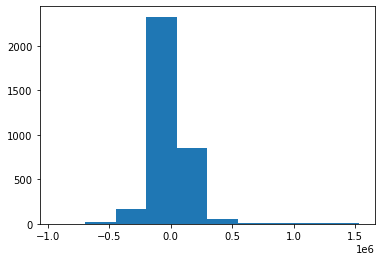

In [100]:
residuals = (y_test - y_test_pred)
plt.hist(residuals)

Somewhat right skewed

<AxesSubplot:xlabel='price', ylabel='price'>

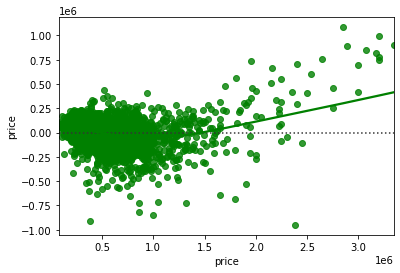

In [101]:
sns.residplot(y_test, residuals, lowess=True, color='g')

Errors are heteroskedastic!!

**Use the log of price**

In [102]:
lr_log = LinearRegression()
lr_log.fit(X_train, np.log(y_train))
print(lr_log.intercept_)
print(lr_log.coef_)

11.938453482005325
[-6.28325767e-02  3.61609123e-02  1.16054460e+00  7.94542554e-01
  6.95652671e-01  7.03883405e-01  6.79191095e-01  2.71828856e-01
  4.67176279e-01  3.24116602e-01  3.38204568e-01  9.38417620e-02
 -1.46416440e-02  4.70621819e-01  5.49089931e-01  4.37099265e-01
  6.36871251e-01  5.52264105e-02  8.82507602e-02 -1.26473990e-02
  7.90827813e-01  5.44482984e-01  1.89794471e-01  1.33381349e+00
  9.27350618e-01  7.65068755e-02  3.47768482e-01  6.74392100e-01
  6.29071730e-01  1.44622471e-01  3.13612333e-01  1.89344925e-01
  3.60095911e-01  3.89931960e-01  3.98080647e-01  5.40363118e-01
  5.97040174e-01  6.19379522e-01  5.24779619e-01  5.78242974e-02
  9.77623349e-01  8.23055302e-01  9.77275326e-01  2.68002141e-01
  8.44821400e-01  3.42974397e-01  1.00515561e+00  1.08021278e+00
  7.98664782e-01  7.67202380e-01  7.95664183e-01  4.18741518e-01
  1.00514682e+00  7.99892050e-01  5.40499626e-01  5.11873535e-01
  4.51523559e-01  6.66216038e-01  6.53455446e-01  2.33258251e-01
  8.97

**Predict Training Set Using Log of Price**

In [103]:
y_log_train_pred = lr_log.predict(X_train)

In [104]:
y_log_train_pred = np.exp(y_log_train_pred)

In [105]:
log_train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_log_train_pred))

print('Root Mean Squared Error:' , log_train_rmse)

Root Mean Squared Error: 181281.61735870258


**Predicting Test Set Using Log of Price**

In [106]:
y_log_test_pred = lr_log.predict(X_test)
y_log_test_pred = np.exp(y_log_test_pred)

In [107]:
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_log_test_pred))

In [108]:
print('Root Mean Squared Error:' , log_test_rmse)

Root Mean Squared Error: 143669.37944996578


**Comparing Test vs Log Test data**

In [109]:
print('Original: ', int(test_rmse), "vs. Logged: ", int(log_test_rmse))

Original:  158214 vs. Logged:  143669


**Check to see if errors are normally distributed Using Log of Price**

(array([2.000e+00, 4.000e+00, 6.000e+00, 3.200e+01, 6.710e+02, 2.599e+03,
        1.170e+02, 1.600e+01, 5.000e+00, 4.000e+00]),
 array([-1506687.05443298, -1216743.29818752,  -926799.54194207,
         -636855.78569662,  -346912.02945116,   -56968.27320571,
          232975.48303974,   522919.2392852 ,   812862.99553065,
         1102806.75177611,  1392750.50802156]),
 <BarContainer object of 10 artists>)

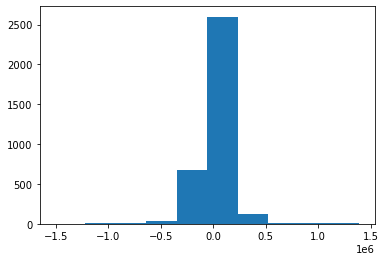

In [110]:
residuals = y_test - y_log_test_pred
plt.hist(residuals)

Normally Distributed Errors

<AxesSubplot:xlabel='price', ylabel='price'>

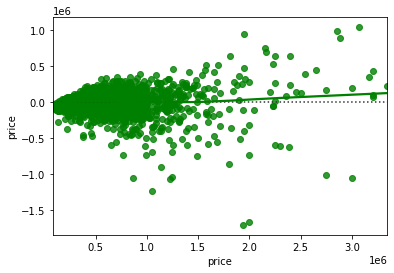

In [111]:
sns.residplot(y_test, residuals, lowess=True, color='g')

Errors lookin homoskedastic

**Model with PolyFeatures(2)**

In [122]:
df_features.columns

Index(['zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipcode_98070', 'zipcode_98072',
       'zipcode_98074', 'zipcode_98075', 'zipcode_98077', 'zipcode_98092',
       'zipcode_98102', 'zipcode_98103', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', '

In [125]:
#cvreate poolynomial featre object that will jsut create interactions
interact = PolynomialFeatures(degree=2, interaction_only=True)
#subset df to only zip codes and sqft living
zips_living = df_features[[*all_zips, 'sqft_living']]
# create interactions using poly functions on zips and living
interact_data = interact.fit_transform(zips_living)
interact_columns = interact.get_feature_names(zips_living.columns)
df_interact = pd.DataFrame(interact_data, columns = interact_columns)
df_interact.head()

,1,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,sqft_living,zipcode_98002 zipcode_98003,zipcode_98002 zipcode_98004,zipcode_98002 zipcode_98005,zipcode_98002 zipcode_98006,zipcode_98002 zipcode_98007,zipcode_98002 zipcode_98008,zipcode_98002 zipcode_98010,zipcode_98002 zipcode_98011,zipcode_98002 zipcode_98014,zipcode_98002 zipcode_98019,zipcode_98002 zipcode_98022,zipcode_98002 zipcode_98023,zipcode_98002 zipcode_98024,zipcode_98002 zipcode_98027,zipcode_98002 zipcode_98028,zipcode_98002 zipcode_98029,zipcode_98002 zipcode_98030,zipcode_98002 zipcode_98031,zipcode_98002 zipcode_98032,zipcode_98002 zipcode_98033,zipcode_98002 zipcode_98034,zipcode_98002 zipcode_98038,zipcode_98002 zipcode_98039,zipcode_98002 zipcode_98040,zipcode_98002 zipcode_98042,zipcode_98002 zipcode_98045,zipcode_98002 zipcode_98052,zipcode_98002 zipcode_98053,zipcode_98002 zipcode_98055,zipcode_98002 zipcode_98056,zipcode_98002 zipcode_98058,zipcode_98002 zipcode_98059,zipcode_98002 zipcode_98065,zipcode_98002 zipcode_98070,zipcode_98002 zipcode_98072,zipcode_98002 zipcode_98074,zipcode_98002 zipcode_98075,zipcode_98002 zipcode_98077,zipcode_98002 zipcode_98092,zipcode_98002 zipcode_98102,zipcode_98002 zipcode_98103,zipcode_98002 zipcode_98105,zipcode_98002 zipcode_98106,zipcode_98002 zipcode_98107,zipcode_98002 zipcode_98108,zipcode_98002 zipcode_98109,zipcode_98002 zipcode_98112,zipcode_98002 zipcode_98115,zipcode_98002 zipcode_98116,zipcode_98002 zipcode_98117,zipcode_98002 zipcode_98118,zipcode_98002 zipcode_98119,zipcode_98002 zipcode_98122,zipcode_98002 zipcode_98125,zipcode_98002 zipcode_98126,zipcode_98002 zipcode_98133,zipcode_98002 zipcode_98136,zipcode_98002 zipcode_98144,zipcode_98002 zipcode_98146,zipcode_98002 zipcode_98148,zipcode_98002 zipcode_98155,zipcode_98002 zipcode_98166,zipcode_98002 zipcode_98168,zipcode_98002 zipcode_98177,zipcode_98002 zipcode_98178,zipcode_98002 zipcode_98188,zipcode_98002 zipcode_98198,zipcode_98002 zipcode_98199,zipcode_98002 sqft_living,zipcode_98003 zipcode_98004,zipcode_98003 zipcode_98005,zipcode_98003 zipcode_98006,zipcode_98003 zipcode_98007,zipcode_98003 zipcode_98008,zipcode_98003 zipcode_98010,zipcode_98003 zipcode_98011,zipcode_98003 zipcode_98014,zipcode_98003 zipcode_98019,zipcode_98003 zipcode_98022,...,zipcode_98119 zipcode_98133,zipcode_98119 zipcode_98136,zipcode_98119 zipcode_98144,zipcode_98119 zipcode_98146,zipcode_98119 zipcode_98148,zipcode_98119 zipcode_98155,zipcode_98119 zipcode_98166,zipcode_98119 zipcode_98168,zipcode_98119 zipcode_98177,zipcode_98119 zipcode_98178,zipcode_98119 zipcode_98188,zipcode_98119 zipcode_98198,zipcode_98119 zipcode_98199,zipcode_98119 sqft_living,zipcode_98122 zipcode_98125,zipcode_98122 zipcode_98126,zipcode_98122 zipcode_98133,zipcode_98122 zipcode_98136,zipcode_98122 zipcode_98144,zipcode_98122 zipcode_98146,zipcode_98122 zipcode_98148,zipcode_98122 zipcode_98155,zipcode_98122 zipcode_98166,zipcode_98122 zipcode_98168,zipcode_98122 zipcode_98177,zipcode_98122 zipcode_98178,zipcode_98122 zipcode_98188,zipcode_98122 zipcode_98198,zipcode_98122 zipcode_9

In [132]:
useless_cols = df_interact.columns[df_interact.apply(lambda col: col.sum() ==0)]

In [133]:
df_interact.drop(useless_cols, axis=1,inplace=True )

In [134]:
pd.concat([df_interact, df_features[['sqftlto, ']])

,1,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,sqft_living,zipcode_98002 sqft_living,zipcode_98003 sqft_living,zipcode_98004 sqft_living,zipcode_98005 sqft_living,zipcode_98006 sqft_living,zipcode_98007 sqft_living,zipcode_98008 sqft_living,zipcode_98010 sqft_living,zipcode_98011 sqft_living,zipcode_98014 sqft_living,zipcode_98019 sqft_living,zipcode_98022 sqft_living,zipcode_98023 sqft_living,zipcode_98024 sqft_living,zipcode_98027 sqft_living,zipcode_98028 sqft_living,zipcode_98029 sqft_living,zipcode_98030 sqft_living,zipcode_98031 sqft_living,zipcode_98032 sqft_living,zipcode_98033 sqft_living,zipcode_98034 sqft_living,zipcode_98038 sqft_living,zipcode_98039 sqft_living,zipcode_98040 sqft_living,zipcode_98042 sqft_living,zipcode_98045 sqft_living,zipcode_98052 sqft_living,zipcode_98053 sqft_living,zipcode_98055 sqft_living,zipcode_98056 sqft_living,zipcode_98058 sqft_living,zipcode_98059 sqft_living,zipcode_98065 sqft_living,zipcode_98070 sqft_living,zipcode_98072 sqft_living,zipcode_98074 sqft_living,zipcode_98075 sqft_living,zipcode_98077 sqft_living,zipcode_98092 sqft_living,zipcode_98102 sqft_living,zipcode_98103 sqft_living,zipcode_98105 sqft_living,zipcode_98106 sqft_living,zipcode_98107 sqft_living,zipcode_98108 sqft_living,zipcode_98109 sqft_living,zipcode_98112 sqft_living,zipcode_98115 sqft_living,zipcode_98116 sqft_living,zipcode_98117 sqft_living,zipcode_98118 sqft_living,zipcode_98119 sqft_living,zipcode_98122 sqft_living,zipcode_98125 sqft_living,zipcode_98126 sqft_living,zipcode_98133 sqft_living,zipcode_98136 sqft_living,zipcode_98144 sqft_living,zipcode_98146 sqft_living,zipcode_98148 sqft_living,zipcode_98155 sqft_living,zipcode_98166 sqft_living,zipcode_98168 sqft_living,zipcode_98177 sqft_living,zipcode_98178 sqft_living,zipcode_98188 sqft_living,zipcode_98198 sqft_living,zipcode_98199 sqft_living
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2070.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2070.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [112]:
poly_2 = PolynomialFeatures(degree=2)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns = poly2_columns)
df_poly2.head()

,1,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,season_sold_Spring,season_sold_Summer,season_sold_Winter,waterfront,view,grade_cat_low,grade_cat_medium,sqft_living,zipcode_98002^2,zipcode_98002 zipcode_98003,zipcode_98002 zipcode_98004,zipcode_98002 zipcode_98005,zipcode_98002 zipcode_98006,zipcode_98002 zipcode_98007,zipcode_98002 zipcode_98008,zipcode_98002 zipcode_98010,zipcode_98002 zipcode_98011,zipcode_98002 zipcode_98014,zipcode_98002 zipcode_98019,zipcode_98002 zipcode_98022,zipcode_98002 zipcode_98023,zipcode_98002 zipcode_98024,zipcode_98002 zipcode_98027,zipcode_98002 zipcode_98028,zipcode_98002 zipcode_98029,zipcode_98002 zipcode_98030,zipcode_98002 zipcode_98031,zipcode_98002 zipcode_98032,zipcode_98002 zipcode_98033,zipcode_98002 zipcode_98034,zipcode_98002 zipcode_98038,zipcode_98002 zipcode_98039,zipcode_98002 zipcode_98040,zipcode_98002 zipcode_98042,zipcode_98002 zipcode_98045,zipcode_98002 zipcode_98052,zipcode_98002 zipcode_98053,zipcode_98002 zipcode_98055,zipcode_98002 zipcode_98056,zipcode_98002 zipcode_98058,zipcode_98002 zipcode_98059,zipcode_98002 zipcode_98065,zipcode_98002 zipcode_98070,zipcode_98002 zipcode_98072,zipcode_98002 zipcode_98074,zipcode_98002 zipcode_98075,zipcode_98002 zipcode_98077,zipcode_98002 zipcode_98092,zipcode_98002 zipcode_98102,zipcode_98002 zipcode_98103,zipcode_98002 zipcode_98105,zipcode_98002 zipcode_98106,zipcode_98002 zipcode_98107,zipcode_98002 zipcode_98108,zipcode_98002 zipcode_98109,zipcode_98002 zipcode_98112,zipcode_98002 zipcode_98115,zipcode_98002 zipcode_98116,zipcode_98002 zipcode_98117,zipcode_98002 zipcode_98118,zipcode_98002 zipcode_98119,zipcode_98002 zipcode_98122,zipcode_98002 zipcode_98125,zipcode_98002 zipcode_98126,zipcode_98002 zipcode_98133,zipcode_98002 zipcode_98136,zipcode_98002 zipcode_98144,zipcode_98002 zipcode_98146,zipcode_98002 zipcode_98148,zipcode_98002 zipcode_98155,zipcode_98002 zipcode_98166,zipcode_98002 zipcode_98168,zipcode_98002 zipcode_98177,...,zipcode_98198 bedrooms_2,zipcode_98198 bedrooms_3,zipcode_98198 bedrooms_4,zipcode_98198 bedrooms_5,zipcode_98198 bedrooms_6,zipcode_98198 bedrooms_7,zipcode_98198 season_sold_Spring,zipcode_98198 season_sold_Summer,zipcode_98198 season_sold_Winter,zipcode_98198 waterfront,zipcode_98198 view,zipcode_98198 grade_cat_low,zipcode_98198 grade_cat_medium,zipcode_98198 sqft_living,zipcode_98199^2,zipcode_98199 bedrooms_1,zipcode_98199 bedrooms_2,zipcode_98199 bedrooms_3,zipcode_98199 bedrooms_4,zipcode_98199 bedrooms_5,zipcode_98199 bedrooms_6,zipcode_98199 bedrooms_7,zipcode_98199 season_sold_Spring,zipcode_98199 season_sold_Summer,zipcode_98199 season_sold_Winter,zipcode_98199 waterfront,zipcode_98199 view,zipcode_98199 grade_cat_low,zipcode_98199 grade_cat_medium,zipcode_98199 sqft_living,bedrooms_1^2,bedrooms_1 bedrooms_2,bedrooms_1 bedrooms_3,bedrooms_1 bedrooms_4,bedrooms_1 bedrooms_5,bedrooms_1 bedrooms_6,bedrooms_1 bedrooms_7,bedrooms_1 season_sold_Spring,bedrooms_1 season_sold_Summer,bedrooms_1 season_sold_W

In [113]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9, test_size=.2)
lr_2 = LinearRegression()
lr_2.fit(X_train, y_train)
y_train_pred = lr_2.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 118170.297356443


In [114]:
y_test_pred = lr_2.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Testing Root Mean Squared Error:' , test_rmse)
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 469613.48378581146
Training:  118170 vs. Testing:  469613


Model is over fit to training data. Need to do some feature selection.

In [120]:
X_train.shape

(13824, 3655)

In [119]:
ols = LinearRegression()
#Create recursive feature eliminator
selector = RFECV(estimator = ols, step=10, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose =1)
#Fit recursive feature eliminator
selector.fit(X_train, y_train)

KeyboardInterrupt: 

In [115]:
from sklearn.feature_selection import RFECV